# Removing the Kenyon cells

In [1]:
import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from giskard.plot import merge_axes
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import FIG_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import (
    SmartSVG,
    draw_hypothesis_box,
    networkplot_simple,
    plot_density,
    plot_pvalues,
    set_theme,
)
from pkg.stats import erdos_renyi_test, stochastic_block_test
from pkg.utils import get_toy_palette, sample_toy_networks
from svgutils.compose import Figure, Panel, Text

DISPLAY_FIGS = True

FILENAME = "kc_minus"

FIG_PATH = FIG_PATH / FILENAME


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

In [2]:

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()
neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "simple_group"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

# Remove kenyon cells
left_nodes["inds"] = range(len(left_nodes))
sub_left_nodes = left_nodes[left_nodes[GROUP_KEY] != "KCs"]
sub_left_inds = sub_left_nodes["inds"].values
right_nodes["inds"] = range(len(right_nodes))
sub_right_nodes = right_nodes[right_nodes[GROUP_KEY] != "KCs"]
sub_right_inds = sub_right_nodes["inds"].values

sub_left_adj = left_adj[np.ix_(sub_left_inds, sub_left_inds)]
sub_right_adj = right_adj[np.ix_(sub_right_inds, sub_right_inds)]
sub_left_labels = sub_left_nodes[GROUP_KEY]
sub_right_labels = sub_right_nodes[GROUP_KEY]

## Methods


A1, A2, node_data = sample_toy_networks()
palette = get_toy_palette()

fig, axs = plt.subplots(2, 2, figsize=(7, 6), gridspec_kw=dict(width_ratios=[1, 1.5]))

ax = axs[0, 0]
networkplot_simple(A1, node_data, palette=palette, ax=ax, group=True)
x, y = node_data[node_data["labels"] == 1][["x", "y"]].mean()
ax.text(x, y, "X", color="darkred", fontsize=80, va="center", ha="center")
ax.set(title="Remove Kenyon cells")
ax.set_ylabel(
    "Left",
    color=network_palette["Left"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

ax = axs[1, 0]
networkplot_simple(A2, node_data, palette=palette, ax=ax, group=True)
x, y = node_data[node_data["labels"] == 1][["x", "y"]].mean()
ax.text(x, y, "X", color="darkred", fontsize=80, va="center", ha="center")
ax.set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)


ax = merge_axes(fig, axs, rows=None, cols=1)
ax.axis("off")
ax.set(xlim=(0, 1), ylim=(0, 1))


kwargs = dict(yskip=0.07, ax=ax, title=True)
draw_hypothesis_box("er", 0.15, 0.8, **kwargs)
draw_hypothesis_box("sbm", 0.15, 0.5, **kwargs)
draw_hypothesis_box("dasbm", 0.15, 0.15, **kwargs)

line1 = mpl.lines.Line2D(
    (0.51, 0.51),
    (0.05, 0.9),
    transform=fig.transFigure,
    color="lightgrey",
    linewidth=1.5,
)

fig.lines = (line1,)


ax.set_title("Re-run all tests")
plt.tight_layout()

gluefig("kc_minus_methods", fig)

## ER test

1.040225929736058e-27


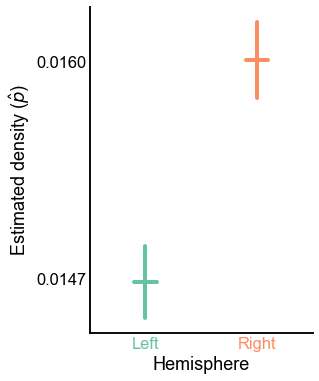

In [3]:

stat, pvalue, misc = erdos_renyi_test(sub_left_adj, sub_right_adj)
print(pvalue)
glue("er_pvalue", pvalue)

fig, ax = plot_density(misc, palette=network_palette)
gluefig("densities", fig)

## SBM test

0.0026526463992977527


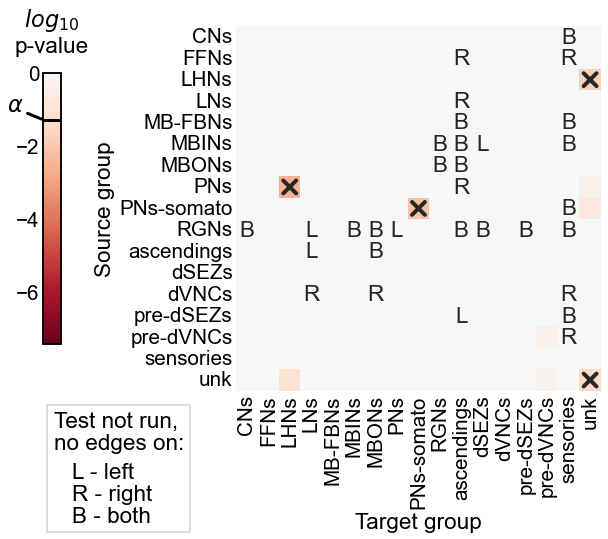

In [4]:

stat, pvalue, misc = stochastic_block_test(
    sub_left_adj,
    sub_right_adj,
    labels1=sub_left_labels,
    labels2=sub_right_labels,
    method="fisher",
    combine_method="tippett",
)
print(pvalue)
glue("sbm_pvalue", pvalue)

set_theme(font_scale=1.25)

fig, ax = plot_pvalues(misc)
gluefig("sbm_pvalues", fig)

## aSBM test

0.5131201032903336


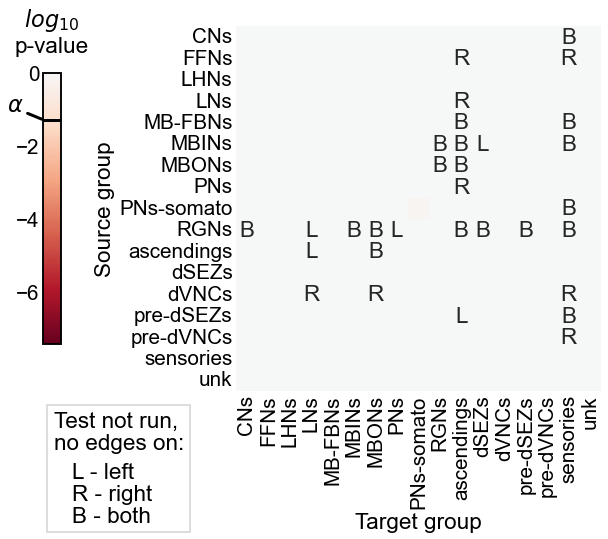

In [5]:

stat, pvalue, misc = stochastic_block_test(
    sub_left_adj,
    sub_right_adj,
    labels1=sub_left_labels,
    labels2=sub_right_labels,
    method="fisher",
    density_adjustment=True,
    combine_method="tippett",
)
print(pvalue)
glue("asbm_pvalue", pvalue)
glue("asbm_pvalue_formatted", f"{pvalue:.2g}")

fig, ax = plot_pvalues(misc)
gluefig("dasbm_pvalues", fig)

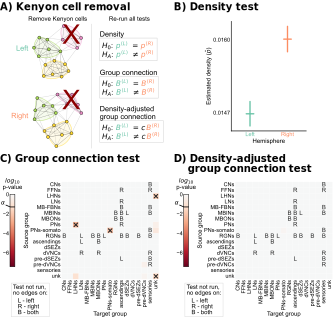

In [6]:

fontsize = 10

methods = SmartSVG(FIG_PATH / "kc_minus_methods.svg")
methods.set_width(200)
methods.move(10, 15)
methods_panel = Panel(
    methods, Text("A) Kenyon cell removal", 0, 10, size=fontsize, weight="bold")
)

er = SmartSVG(FIG_PATH / "densities.svg")
er.set_width(130)
er.move(30, 20)
er_panel = Panel(er, Text("B) Density test", 0, 10, size=fontsize, weight="bold"))
er_panel.move(methods.width * 0.87, 0)

sbm = SmartSVG(FIG_PATH / "sbm_pvalues.svg")
sbm.set_width(200)
sbm.move(0, 25)
sbm_panel = Panel(
    sbm, Text("C) Group connection test", 0, 10, size=fontsize, weight="bold")
)
sbm_panel.move(0, methods.height * 0.9)

asbm = SmartSVG(FIG_PATH / "dasbm_pvalues.svg")
asbm.set_width(200)
asbm.move(0, 25)
asbm_panel = Panel(
    asbm,
    Text("D) Density-adjusted", 0, 10, size=fontsize, weight="bold"),
    Text("group connection test", 14, 20, size=fontsize, weight="bold"),
)
asbm_panel.move(methods.width * 0.87, methods.height * 0.9)


fig = Figure(
    (methods.width + er.width) * 1.02,
    (methods.height + sbm.height) * 0.95,
    methods_panel,
    er_panel,
    sbm_panel,
    asbm_panel,
)
fig.save(FIG_PATH / "kc_minus_composite.svg")
fig

In [7]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:10.285544
Completed at 2022-03-21 10:02:07.518540
